In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

from keras import models, layers, optimizers

In [25]:
# instantiate the VGG16 convolutional base
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# feature extraction without data augmentation(fast) 

In [27]:
# extract features
base_dir = '/home/ls283h/Work/Notebooks/Data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [16]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #predict only with conv
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# defining and training the densely connected classifier

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 645us/step - loss: 0.5891 - acc: 0.6790 - val_loss: 0.4292 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 409us/step - loss: 0.4206 - acc: 0.8150 - val_loss: 0.3604 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 1s 411us/step - loss: 0.3565 - acc: 0.8520 - val_loss: 0.3138 - val_acc: 0.8920
Epoch 4/30
2000/2000 [==============================] - 1s 412us/step - loss: 0.3032 - acc: 0.8815 - val_loss: 0.2876 - val_acc: 0.8960
Epoch 5/30
2000/2000 [==============================] - 1s 414us/step - loss: 0.2862 - acc: 0.8810 - val_loss: 0.2742 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 1s 419

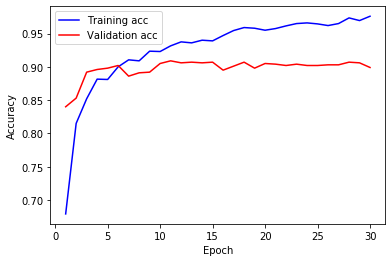

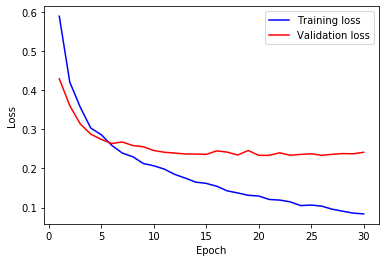

In [6]:
# Display curves of loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## feature extraction with data augmentation(slow) 

In [35]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
# number of trainable weights before freezing the model
len(model.trainable_weights)

4

In [38]:
# Freeze the convolutional base of the model
conv_base.trainable = False

In [39]:
# number of trainable weights after freezing the model
len(model.trainable_weights)

4

In [40]:
# training the model end to end with a frozen convolutional base

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
 
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 14s 136ms/step - loss: 0.7075 - acc: 0.5855 - val_loss: 0.5093 - val_acc: 0.7870
Epoch 2/30
100/100 [==============================] - 12s 120ms/step - loss: 0.5858 - acc: 0.6875 - val_loss: 0.4316 - val_acc: 0.8350
Epoch 3/30
100/100 [==============================] - 12s 123ms/step - loss: 0.5163 - acc: 0.7440 - val_loss: 0.3890 - val_acc: 0.8350
Epoch 4/30
100/100 [==============================] - 13s 125ms/step - loss: 0.4845 - acc: 0.7760 - val_loss: 0.3389 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 12s 122ms/step - loss: 0.4525 - acc: 0.7955 - val_loss: 0.3140 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 12s 121ms/step - loss: 0.4462 - acc: 0.7870 - val_loss: 0.3273 - val_acc: 0.8670
Epoch 7/30
100/100 [==============================] - 12s 120ms/step - loss: 0.4280 - acc: 0.8020 - val_lo

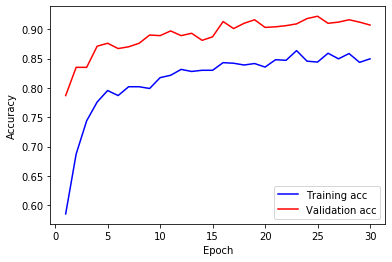

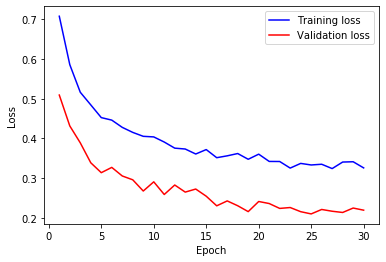

In [41]:
# Display curves of loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Fine-tuning

Fine-tuning consists of unfreezing a few of the deep layers of a frozen model base

Steps:
1. Add custom network on top of an arealdy-trained base network
2. Freeze the base network
3. Train the added part (usually the classifier, that is, the Dense part)
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the added part

Steps 1, 2 e 3 completed when doing feature extraction.

In [42]:
# Freezing all layers up to a specific one
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
# fine-tuning the model
#very low LR to not harm learned representations
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)


Epoch 1/100
100/100 [==============================] - 14s 138ms/step - loss: 0.3281 - acc: 0.8525 - val_loss: 0.1767 - val_acc: 0.9240
Epoch 2/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2800 - acc: 0.8775 - val_loss: 0.1550 - val_acc: 0.9310
Epoch 3/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2533 - acc: 0.8915 - val_loss: 0.1902 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2536 - acc: 0.8940 - val_loss: 0.1488 - val_acc: 0.9420
Epoch 5/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2188 - acc: 0.9050 - val_loss: 0.1249 - val_acc: 0.9460
Epoch 6/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2282 - acc: 0.9085 - val_loss: 0.1061 - val_acc: 0.9580
Epoch 7/100
100/100 [==============================] - 12s 125ms/step - loss: 0.1920 - acc: 0.9240 - val_loss: 0.1023 - val_acc: 0.9610
Epoch 8/100
100/100 [===========================

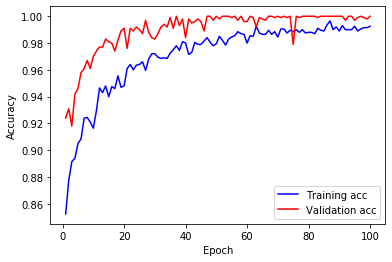

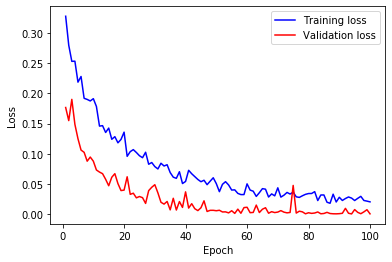

In [44]:
# Display curves of loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [47]:
# evaluate the model on the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 1000 images belonging to 2 classes.
test acc: 0.9399999916553498
test loss: 0.3376662297892835
